In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 

# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')

In [3]:
base_csv = './IMDB Dataset/IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
X,y = df['review'].values,df['sentiment'].values

# 切分訓練集和測試集
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 再從訓練集中切分出驗證集
x_test, x_val, x_test, y_val = train_test_split(x_test, x_test, test_size=0.5, random_state=42)  # 0.25 x 0.8 = 0.2

print(f'shape of train data is {x_train.shape}')
print(f'shape of validation data is {x_val.shape}')
print(f'shape of test data is {x_test.shape}')


shape of train data is (40000,)
shape of validation data is (5000,)
shape of test data is (5000,)


In [26]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    # remove URL
    s = re.sub(r'https?://\S+|www\.\S+','',s)
    #remove HTML label
    s = re.sub('br','',s)

    return s

def remove_stopwords(X):
    word_list=[]
    stop_words = set(stopwords.words('english')) 
    remain_words = ['but','not','no','nor','too','very']
    lemmatizer = WordNetLemmatizer()

    #Remove emotional vocab
    for word in remain_words:
        stop_words.discard(word)

    for word in X.lower().split():
        word = preprocess_string(word)
        word = lemmatizer.lemmatize(word)
        if word not in stop_words and word != '':
            word_list.append(word)
    return word_list

In [ ]:
word_list = [remove_stopwords(x) for x in df[df['sentiment']=='positive']['review']]
word_list

In [108]:
def tf_idf_df(word_list):
# 將word_list轉換成文本格式
word_list_text = [' '.join(words) for words in word_list]

# 初始化TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# 適合模型
tfidf_matrix = tfidf_vectorizer.fit_transform(word_list_text)

# 檢查特徵名稱
feature_names = tfidf_vectorizer.get_feature_names_out()

# 計算每個詞彙的平均TF-IDF值
average_tfidf_values = np.mean(tfidf_matrix, axis=0)

# 創建一個包含詞彙和平均TF-IDF值的DataFrame
average_tfidf_df = pd.DataFrame({'Term': feature_names, 'Average_TF-IDF': average_tfidf_values.A1})

return average_tfidf_df

              Term  Average_TF-IDF
0             ____        0.000014
1            _____        0.000016
2           ______        0.000014
3          _______        0.000003
4         ________        0.000013
...            ...             ...
100587        ücke        0.000013
100588        ünel        0.000003
100589  ünfaithful        0.000005
100590          ýs        0.000007
100591         þór        0.000016

[100592 rows x 2 columns]


In [115]:
average_tfidf_df.sort_values(by='Average_TF-IDF', ascending=False)

,Term,Average_TF-IDF
57947,movie,4.796122e-02
30531,film,4.445799e-02
96040,wa,4.058133e-02
11223,but,3.216205e-02
61211,not,2.619037e-02
...,...,...
6002,awled,6.872423e-07
15262,clotheslining,6.872423e-07
61681,nwo,6.872423e-07
41565,hurracanrana,6.872423e-07


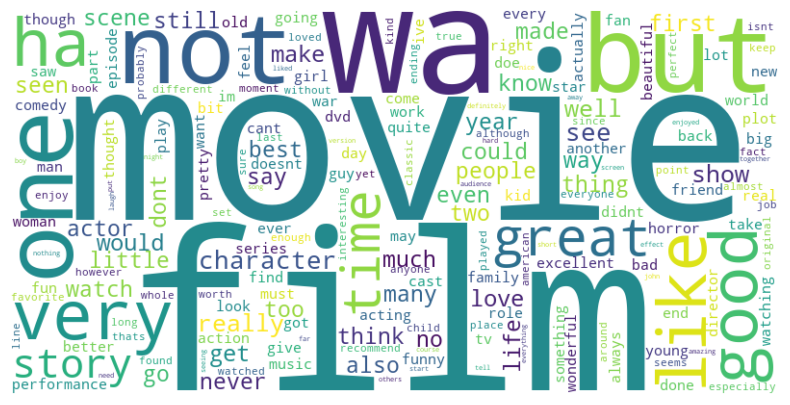

In [116]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 將詞彙和對應的TF-IDF值轉換為字典
word_tfidf_dict = dict(zip(average_tfidf_df['Term'], average_tfidf_df['Average_TF-IDF']))

# 初始化WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white')

# 將詞彙和對應的TF-IDF值生成文字雲
wordcloud.generate_from_frequencies(word_tfidf_dict)

# 顯示文字雲
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [6]:
# 初始化 TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# 將 x_train 資料轉換為 TF-IDF 向量
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

# 將 y_train 轉換為數值型態（例如，0 表示 negative，1 表示 positive）
y_train_numerical = [1 if label == 'positive' else 0 for label in y_train]